In [55]:
import numpy as np
import pandas as pd

In [56]:
data=pd.read_csv('jupiter_intern.csv')
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   25000 non-null  int64  
 1   age                           25000 non-null  int64  
 2   gender                        25000 non-null  object 
 3   location                      25000 non-null  object 
 4   monthly_income                25000 non-null  int64  
 5   monthly_emi_outflow           25000 non-null  int64  
 6   current_outstanding           25000 non-null  int64  
 7   credit_utilization_ratio      25000 non-null  float64
 8   num_open_loans                25000 non-null  int64  
 9   repayment_history_score       25000 non-null  int64  
 10  dpd_last_3_months             25000 non-null  int64  
 11  num_hard_inquiries_last_6m    25000 non-null  int64  
 12  recent_credit_card_usage      25000 non-null  int64  
 13  r

,customer_id,age,monthly_income,monthly_emi_outflow,current_outstanding,credit_utilization_ratio,num_open_loans,repayment_history_score,dpd_last_3_months,num_hard_inquiries_last_6m,recent_credit_card_usage,recent_loan_disbursed_amount,total_credit_limit,months_since_last_default
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,22526.000000
mean,54831.498200,42.570720,50146.120400,17493.130200,151221.507840,0.550175,2.004680,50.063960,44.906280,1.493120,20044.057680,50370.614840,325862.848120,29.884311
std,26305.556359,12.701172,14985.536777,9206.484728,75389.863574,0.260388,1.413994,29.119459,26.323886,1.221578,7892.320534,24489.132585,143078.710804,17.564289
min,10002.000000,21.000000,10000.000000,2000.000000,10540.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30288.000000,0.000000
25%,31800.750000,32.000000,40057.500000,10040.000000,91362.500000,0.320000,1.000000,25.000000,22.000000,1.000000,14703.000000,33243.000000,215025.500000,15.000000
50%,54787.500000,43.000000,50090.500000,16203.500000,140572.000000,0.550000,2.000000,50.000000,45.000000,1.000000,19986.500000,50279.500000,307560.500000,30.000000
75%,77863.000000,54.000000,60271.250000,23571.250000,201118.750000,0.780000,3.000000,75.000000,68.000000,2.000000,25397.000000,67087.000000,417246.250000,45.000000
max,99987.000000,64.000000,108499.000000,59009.000000,453792.000000,1.000000,10.000000,100.000000,90.000000,9.000000,51029.000000,154673.000000,800000.000000,60.000000


In [57]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

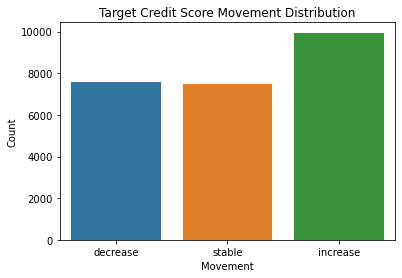

In [58]:
sns.countplot(x='target_credit_score_movement', data=data)
plt.title("Target Credit Score Movement Distribution")
plt.xlabel("Movement")
plt.ylabel("Count")
plt.show()

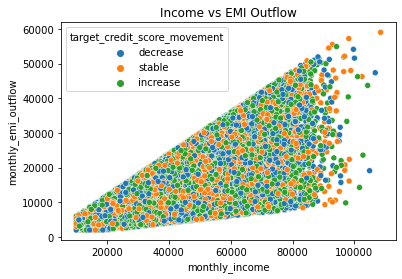

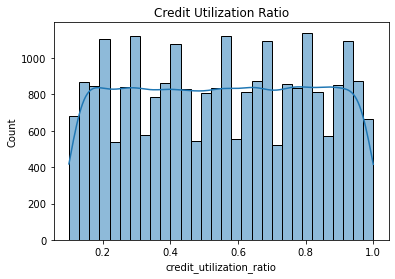

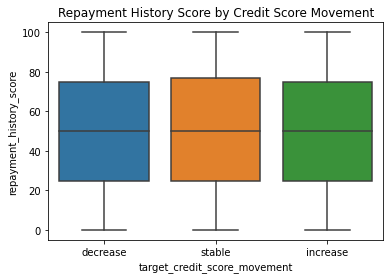

In [59]:
# Monthly income vs EMI outflow
sns.scatterplot(x='monthly_income', y='monthly_emi_outflow', hue='target_credit_score_movement', data=data)
plt.title("Income vs EMI Outflow")
plt.show()

# Credit Utilization
sns.histplot(data['credit_utilization_ratio'], bins=30, kde=True)
plt.title("Credit Utilization Ratio")
plt.show()

# Repayment Score
sns.boxplot(x='target_credit_score_movement', y='repayment_history_score', data=data)
plt.title("Repayment History Score by Credit Score Movement")
plt.show()

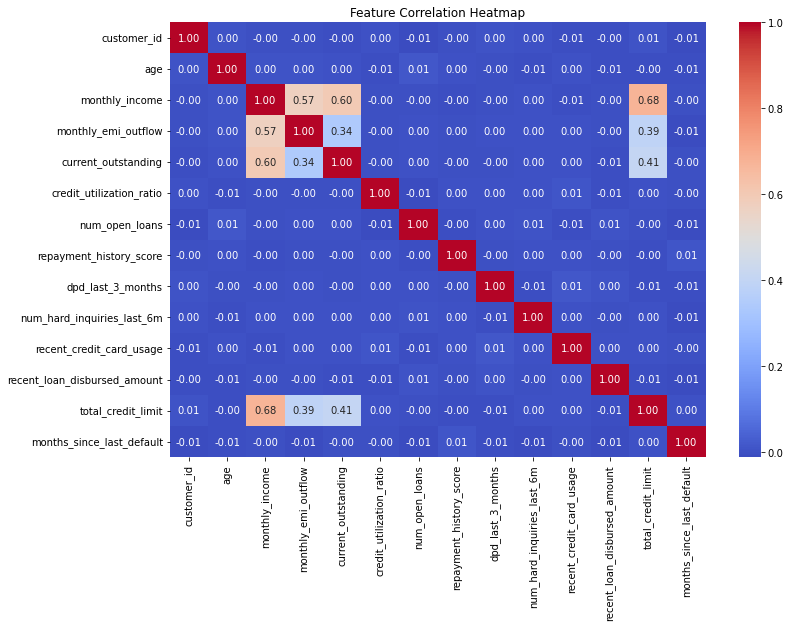

In [60]:
correlation_matrix = data.select_dtypes(include=[int, float]).corr()

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Model Deployation

In [61]:
def determine_credit_score_movement(row):
    emi_income_ratio = row['monthly_emi_outflow'] / row['monthly_income']
    if row['dpd_last_3_months'] > 60 and row['credit_utilization_ratio'] > 0.8 and row['num_hard_inquiries_last_6m'] > 3:
        return 'decrease'
    elif emi_income_ratio < 0.3 and row['repayment_history_score'] > 80:
        return 'increase'
    else:
        return 'stable'

In [62]:
data['target_credit_score_movement'] = data.apply(determine_credit_score_movement, axis=1)

In [63]:
features = data.drop(columns=['customer_id', 'target_credit_score_movement'])
features = pd.get_dummies(features)  # One-hot encode categorical variables
labels = data['target_credit_score_movement']

In [64]:
features.fillna(-1, inplace=True)

In [65]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded)

In [67]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [68]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

# Model Evaluation 

In [69]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()
y_pred

array([2, 2, 1, ..., 2, 2, 2])

In [70]:
from sklearn import metrics

In [71]:
conf_matrix = confusion_matrix(y_test, y_pred)
report_df

,precision,recall,f1-score,support
decrease,1.000000,0.950000,0.974359,20.0000
increase,0.879271,0.957816,0.916865,403.0000
stable,0.996037,0.988420,0.992214,4577.0000
accuracy,0.985800,0.985800,0.985800,0.9858
macro avg,0.958436,0.965412,0.961146,5000.0000
weighted avg,0.986642,0.985800,0.986069,5000.0000


In [72]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [0, 1,2])


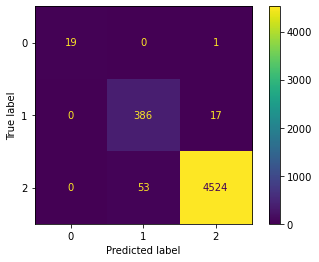

In [73]:
cm_display.plot()
plt.show()

In [74]:
conf_matrix 


array([[  19,    0,    1],
       [   0,  386,   17],
       [   0,   53, 4524]], dtype=int64)